In [47]:
#input convolutional network accepts 2-dim and 3-dim -
#kernel size - 3x3
#sliding window principle 
#polling principle - e.g  max pooling  
#multiple layers - 3-4-5. 
#cats vs dogs 

#cats vs dogs microsoft datasets
#https://www.microsoft.com/en-us/download/details.aspx?id=54765

import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F


#flag for preprocessing / alternative seperate
REBUILD_DATA = True



In [48]:


class DogsVSCats():
    IMG_SIZE=50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1} # we should one hot encode this
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            
            #list over directory
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                        
                    if label == self.CATS:
                        self.catcount +=1
                    elif label == self.DOGS:
                        self.dogcount +=1
                except Exception as e:
                    #print(e)
                    pass
                
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:",self.dogcount)


In [27]:
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()




  1%|          | 93/12501 [00:00<00:13, 929.85it/s]

PetImages/Cat


  1%|          | 91/12501 [00:00<00:13, 900.32it/s]

PetImages/Dog


100%|██████████| 12501/12501 [00:13<00:00, 897.14it/s]


Cats: 12476
Dogs: 12470


In [28]:
REBUILD_DATA = False

training_data = np.load("training_data.npy", allow_pickle=True)

In [15]:
print(len(training_data))

24946


In [16]:
print(training_data[0])

[array([[ 97, 107, 112, ..., 134, 134, 134],
       [101, 111, 117, ..., 138, 138, 137],
       [104, 111, 120, ..., 142, 138, 140],
       ...,
       [ 70,  68,  77, ..., 107, 130,  96],
       [ 58,  64, 182, ...,  99,  54,  47],
       [107, 158, 173, ...,  66,  70,  69]], dtype=uint8)
 array([1., 0.])]


(24946, 2)
[1. 0.]


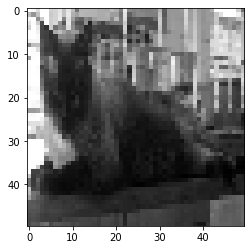

In [29]:
import matplotlib.pyplot as plt

print(training_data.shape)
plt.imshow(training_data[2][0], cmap="gray")
print(training_data[2][1])

In [37]:

class Net (nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512,2)
        
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2)) 
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2)) 
        
      #  print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        
        
     

In [31]:
device = torch.device("cuda:0")
device

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("running on the GPU")
else:
    device = torch.device("cpu")
    print ("running on the CPU")
    
torch.cuda.device_count()

running on the GPU


1

In [97]:
net = Net().to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [34]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr =0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
#print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))


22452
2494


In [99]:


def train(net):
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    BATCH_SIZE = 100
    EPOCHS = 5

    for epoch in range(EPOCHS):
        for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
            #print(i, i+BATCH_SIZE)
            batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
            batch_y = train_y[i:i+BATCH_SIZE]

            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            net.zero_grad()
            optimizer.zero_grad()   # zero the gradient buffers
            
            outputs = net(batch_X)
            loss = loss_function(outputs,batch_y)
            loss.backward()
            optimizer.step()
            
        print(f"Epoche :{epoch}. Loss:{loss}")
        
train(net)

  5%|▌         | 12/225 [00:00<00:01, 115.07it/s]

Epoche :0. Loss:0.20596478879451752


  5%|▌         | 12/225 [00:00<00:01, 115.36it/s]

Epoche :1. Loss:0.18500879406929016


  5%|▌         | 12/225 [00:00<00:01, 116.41it/s]

Epoche :2. Loss:0.18603406846523285


  5%|▌         | 12/225 [00:00<00:01, 115.25it/s]

Epoche :3. Loss:0.13378140330314636


100%|██████████| 225/225 [00:02<00:00, 109.90it/s]

Epoche :4. Loss:0.09655433148145676


  5%|▌         | 12/225 [00:00<00:01, 117.76it/s]

Epoche :0. Loss:0.053638532757759094


  5%|▌         | 12/225 [00:00<00:01, 118.03it/s]

Epoche :1. Loss:0.028132425621151924


  5%|▌         | 12/225 [00:00<00:01, 117.68it/s]

Epoche :2. Loss:0.015857433900237083


  5%|▌         | 12/225 [00:00<00:01, 117.86it/s]

Epoche :3. Loss:0.024577751755714417


  5%|▌         | 12/225 [00:00<00:01, 117.60it/s]

Epoche :4. Loss:0.02013932727277279


  5%|▌         | 12/225 [00:00<00:01, 117.75it/s]

Epoche :5. Loss:0.021833471953868866


  5%|▌         | 12/225 [00:00<00:01, 117.61it/s]

Epoche :6. Loss:0.020615922287106514


  5%|▌         | 12/225 [00:00<00:01, 116.40it/s]

Epoche :7. Loss:0.018563738092780113


  5%|▌         | 12/225 [00:00<00:01, 116.97it/s]

Epoche :8. Loss:0.005241451319307089


  5%|▌         | 12/225 [00:00<00:01, 117.37it/s]

Epoche :9. Loss:0.01574047841131687


  5%|▌         | 12/225 [00:00<00:01, 117.08it/s]

Epoche :10. Loss:0.004144974052906036


  5%|▌         | 12/225 [00:00<00:01, 117.88it/s]

Epoche :11. Loss:0.028531624004244804


  5%|▌         | 12/225 [00:00<00:01, 117.36it/s]

Epoche :12. Loss:0.02062334306538105


  5%|▌         | 12/225 [00:00<00:01, 117.49it/s]

Epoche :13. Loss:0.01085684448480606


  5%|▌         | 12/225 [00:00<00:01, 117.37it/s]

Epoche :14. Loss:0.00021171799744479358


  5%|▌         | 12/225 [00:00<00:01, 117.14it/s]

Epoche :15. Loss:0.0054894001223146915


  5%|▌         | 12/225 [00:00<00:01, 117.09it/s]

Epoche :16. Loss:0.022593384608626366


  5%|▌         | 12/225 [00:00<00:01, 117.41it/s]

Epoche :17. Loss:0.010571279563009739


  5%|▌         | 12/225 [00:00<00:01, 117.43it/s]

Epoche :18. Loss:0.018361873924732208


  5%|▌         | 12/225 [00:00<00:01, 117.10it/s]

Epoche :19. Loss:0.02333603799343109


  5%|▌         | 12/225 [00:00<00:01, 116.37it/s]

Epoche :20. Loss:0.009724601171910763


  5%|▌         | 12/225 [00:00<00:01, 116.89it/s]

Epoche :21. Loss:0.00808881875127554


  5%|▌         | 12/225 [00:00<00:01, 116.31it/s]

Epoche :22. Loss:0.001616777153685689


  5%|▌         | 12/225 [00:00<00:01, 116.22it/s]

Epoche :23. Loss:0.03395316004753113


  5%|▌         | 12/225 [00:00<00:01, 116.60it/s]

Epoche :24. Loss:0.001894863205961883


  5%|▌         | 12/225 [00:00<00:01, 116.16it/s]

Epoche :25. Loss:0.0004986743442714214


  5%|▌         | 12/225 [00:00<00:01, 116.21it/s]

Epoche :26. Loss:0.00038572988705709577


  5%|▌         | 12/225 [00:00<00:01, 115.47it/s]

Epoche :27. Loss:0.000169038146850653


  5%|▌         | 12/225 [00:00<00:01, 116.12it/s]

Epoche :28. Loss:0.0013664591824635863


100%|██████████| 225/225 [00:02<00:00, 109.57it/s]

Epoche :29. Loss:0.0006230350700207055


In [100]:
test_X.to(device)
test_y.to(device)

def test(net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i in tqdm(range(len(test_X))):
            real_class = torch.argmax(test_y[i].to(device))
            net_out = net(test_X[i].view(-1,1,50,50).to(device))[0]
            predicted_class = torch.argmax(net_out)
            if predicted_class == real_class:
                correct +=1
            total +=1

    print(correct)
    print(total)
    print("accuracy", round(correct/total,3))

test(net)

100%|██████████| 2494/2494 [00:01<00:00, 1612.68it/s]

1828
2494
accuracy 0.733
